### This notebook is used to examine global sea surface temperature as well as in the arctic and antarctic regions. The dataset used to look a this information spans from 
### January 1993 to December 2022, and is accompanied by another dataset that can be used to mask the data on land.
##### Resources in this notebook are largely supplied by Dr. Beadling, and assembled by Colin Krzystek

In [1]:
import matplotlib.pyplot as plt 
import xarray as xr
import numpy as np
import momlevel as ml

In [2]:
%matplotlib inline                           
%config InlineBackend.figure_format='retina' 
plt.rcParams['figure.figsize'] = 12,6  

### Load in a Dataset of observed monthly-mean SST from OISST that contains data from January 1993 to Dec 2022. We also load in our land-sea mask for the dataset to be used later in a global mean calculation.

In [3]:
## Load a dataset of SST from OISST and assign to a variable called SST_OISST:
SST_OISST = xr.open_dataset('/home/ees_student/Krzystek_Unit5/data/sst.oisst.mon.mean.1993_2022.nc',
                           use_cftime=True)
                           ### this use_cftime=True allows Xarray to interpret time coords as calendar.

## load in a dataset that contains a land-sea mask:
OISST_landsea_mask = xr.open_dataset('/home/ees_student/Krzystek_Unit5/data/lsmask.nc')

### Compute and produce a timeseries of the following and describe your observations:
* ### area-weighted global average SST
* ### area-weighted arctic SST (55N to 90N)
* ### area-weighted antarctic SST (55S to 90S)

In [4]:
SST_OISST  #Taking a look at the SST Dataset

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) object 1993-01-01 00:00:00 ... 2022-12-01 00:00:00
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    CDI:            Climate Data Interface version 1.9.10 (https://mpimet.mpg...
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    institution:    NOAA/National Centers for Environmental Information
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...
    CDO:            Climate Data Operators version 1.9.10 (https://mpimet.mpg...
    history:        Tue Aug  8 15:12:26 2023: ncks -d time,4, /scratch/csmith...
    NCO:            netCDF Operators version 4.8.1 (Homepage = http://nco.sf....

In [5]:
SST = SST_OISST.sst  #Selecting the SST dat from the dataset

In [6]:
# The following function is used to create weights for the Earths grid space.
import warnings 

def standard_grid_cell_area(lat, lon, rE=6371.0e3):
    """ computes the cell area for a standard spherical grid """

    dLat = lat[1] - lat[0]
    dLon = lon[1] - lon[0]
    area = np.empty((len(lat), len(lon)))
    for j in range(0, len(lat)):
        for i in range(0, len(lon)):
            lon1 = lon[i] + dLon / 2
            lon0 = lon[i] - dLon / 2
            lat1 = lat[j] + dLat / 2
            lat0 = lat[j] - dLat / 2
            area[j, i] = (
                (np.pi / 180.0)
                * rE
                * rE
                * np.abs(np.sin(np.radians(lat0)) - np.sin(np.radians(lat1)))
                * np.abs(lon0 - lon1)
            )
    return area

In [7]:
lat_sst = SST.coords['lat'].values #1-D numpy array of model's latitude values
lon_sst = SST.coords['lon'].values #1-D numpy array of model's longitude values

# make sure to replace the name of the data array if you chose a 
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.

# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_sst,lon_sst)  

# The areacella_xarray function outputs a numpy array. Convert this back into 
# and xarray DataArray for further use. If this is a field you will be using 
# often. You may wish to save this newly created DataArray as a Dataset and save 
# as a netcdf file.

# here we assign dimensions and coordinates that are the same as our original SST array:

areacell_xarray = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(SST.coords['lat'],\
                                                        SST.coords['lon']))

In [8]:
weights = areacell_xarray*OISST_landsea_mask.mask   #removing the data on land
weighted_average_SST1 = SST.weighted(weights).mean(['lat', 'lon']) #Spatially weighting the SST data
weighted_average_SST = ml.util.annual_average(weighted_average_SST1,tcoord='time')

In [9]:
SST_arctic = SST.sel(lat=slice(55,90))
lat_sst_arctic = SST_arctic.coords['lat'].values #1-D numpy array of model's latitude values
lon_sst_arctic = SST_arctic.coords['lon'].values #1-D numpy array of model's longitude values

# make sure to replace the name of the data array if you chose a 
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.

# Pass the arrays to the standard_grid_cell_area function
areacell_arctic = standard_grid_cell_area(lat_sst_arctic,lon_sst_arctic)  

# The areacella_xarray function outputs a numpy array. Convert this back into 
# and xarray DataArray for further use. If this is a field you will be using 
# often. You may wish to save this newly created DataArray as a Dataset and save 
# as a netcdf file.

# here we assign dimensions and coordinates that are the same as our original SST array:

areacell_xarray = xr.DataArray(areacell_arctic,dims=({'lat':180, 'lon':360}),\
                                                coords=(SST_arctic.coords['lat'],\
                                                        SST_arctic.coords['lon']))
Arctic_weighted_average_SST1 = SST_arctic.weighted(weights).mean(['lat', 'lon'])      #Spatially weighing the data
Arctic_weighted_average_SST = ml.util.annual_average(Arctic_weighted_average_SST1,tcoord='time') #averaging the data over each year

In [10]:
SST_ant = SST.sel(lat=slice(-90,-55))
lat_sst_ant = SST_ant.coords['lat'].values #1-D numpy array of model's latitude values
lon_sst_ant = SST_ant.coords['lon'].values #1-D numpy array of model's longitude values

areacell_ant = standard_grid_cell_area(lat_sst_ant,lon_sst_ant)  
areacell_xarray = xr.DataArray(areacell_ant,dims=({'lat':180, 'lon':360}),\
                                                coords=(SST_ant.coords['lat'],\
                                                        SST_ant.coords['lon']))
Ant_weighted_average_SST1 = SST_ant.weighted(weights).mean(['lat', 'lon'])      #Spatially weighing the data
Ant_weighted_average_SST = ml.util.annual_average(Ant_weighted_average_SST1,tcoord='time') #averaging the data over each year

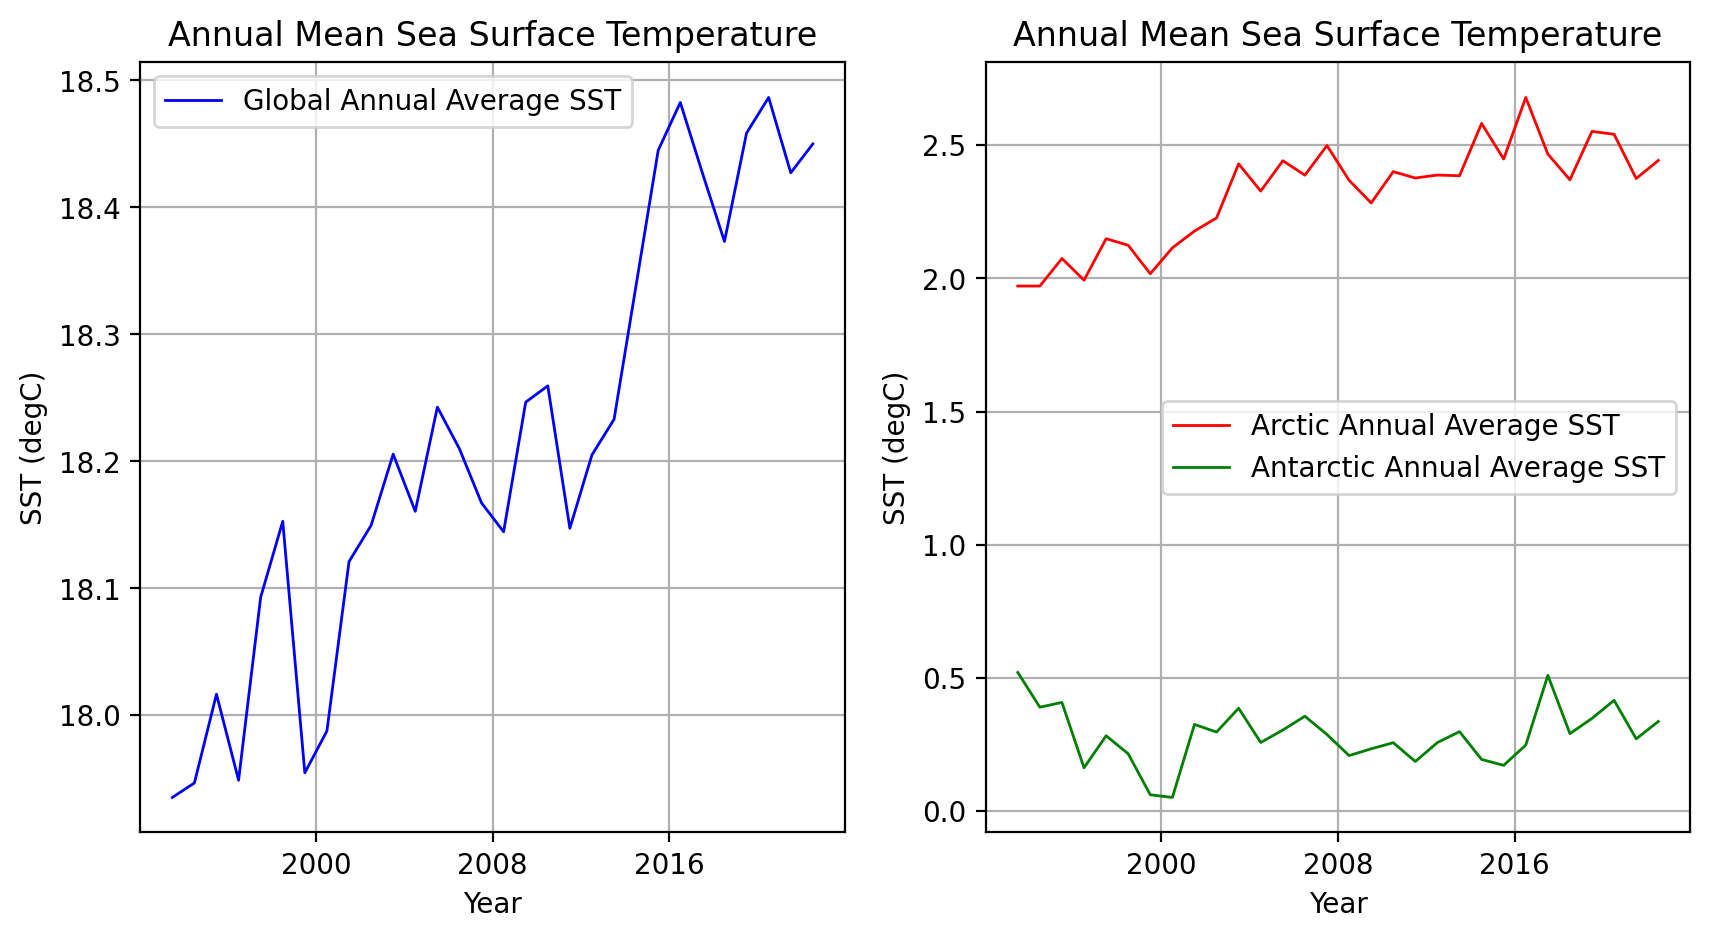

In [13]:
fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2,figsize = (10, 5))   #Plotting all three data sets
weighted_average_SST.plot(ax=ax0, #plotted on left chart
        linewidth=1,label='Global Annual Average SST',
        color='blue')
Arctic_weighted_average_SST.plot(ax=ax1,  #plotted on right chart
        linewidth=1,label='Arctic Annual Average SST',
        color='red')
Ant_weighted_average_SST.plot(ax=ax1,  #plotted on right chart
        linewidth=1,label='Antarctic Annual Average SST',
        color='green')
#chart labels
ax0.set_title('Annual Mean Sea Surface Temperature')
ax0.set_ylabel('SST (degC)')
ax0.set_xlabel('Year')
#adding grid and legend
ax0.grid(linestyle='-')
ax0.legend()

ax1.set_title('Annual Mean Sea Surface Temperature')
ax1.set_ylabel('SST (degC)')
ax1.set_xlabel('Year')

ax1.grid(linestyle='-')
ax1.legend()

**Figure 1.** Time series of Sea Surface Temperature (SST) both globally and in the polar regions over the past 30 years. a) Global SST b) Arctic SST displayed in red and the antarctic SST dsiplayed in green. This figure was produced using the SST dataset for the past 30 years as well as the land mask dataset to eliminate all data over land.

### Produce a figure with 4 subplots that shows the global seasonal time-averaged (1993 to 2022) SST.

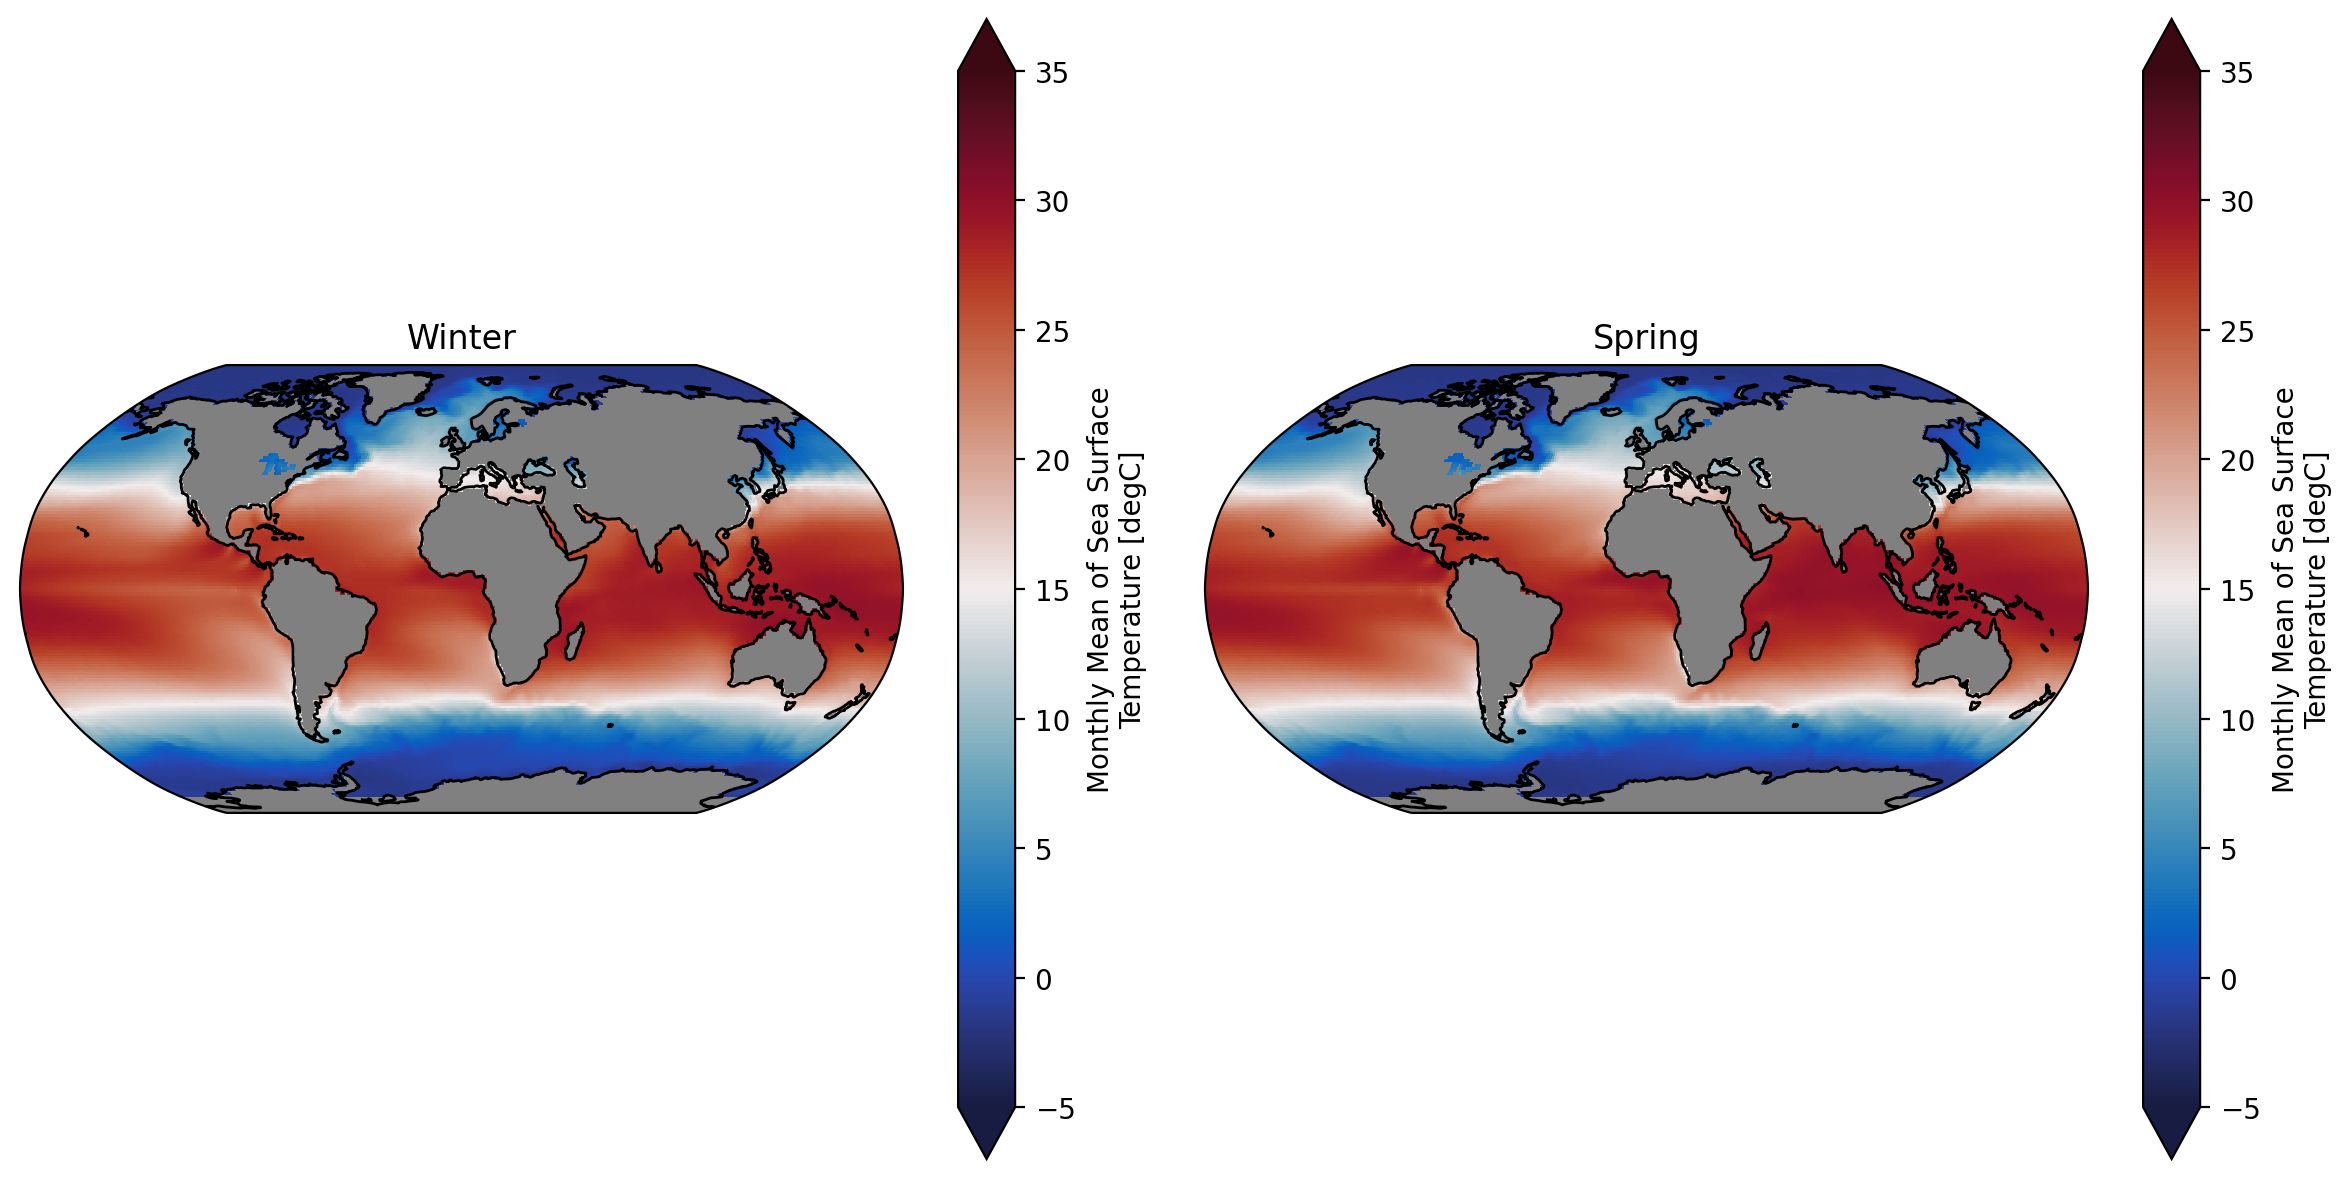

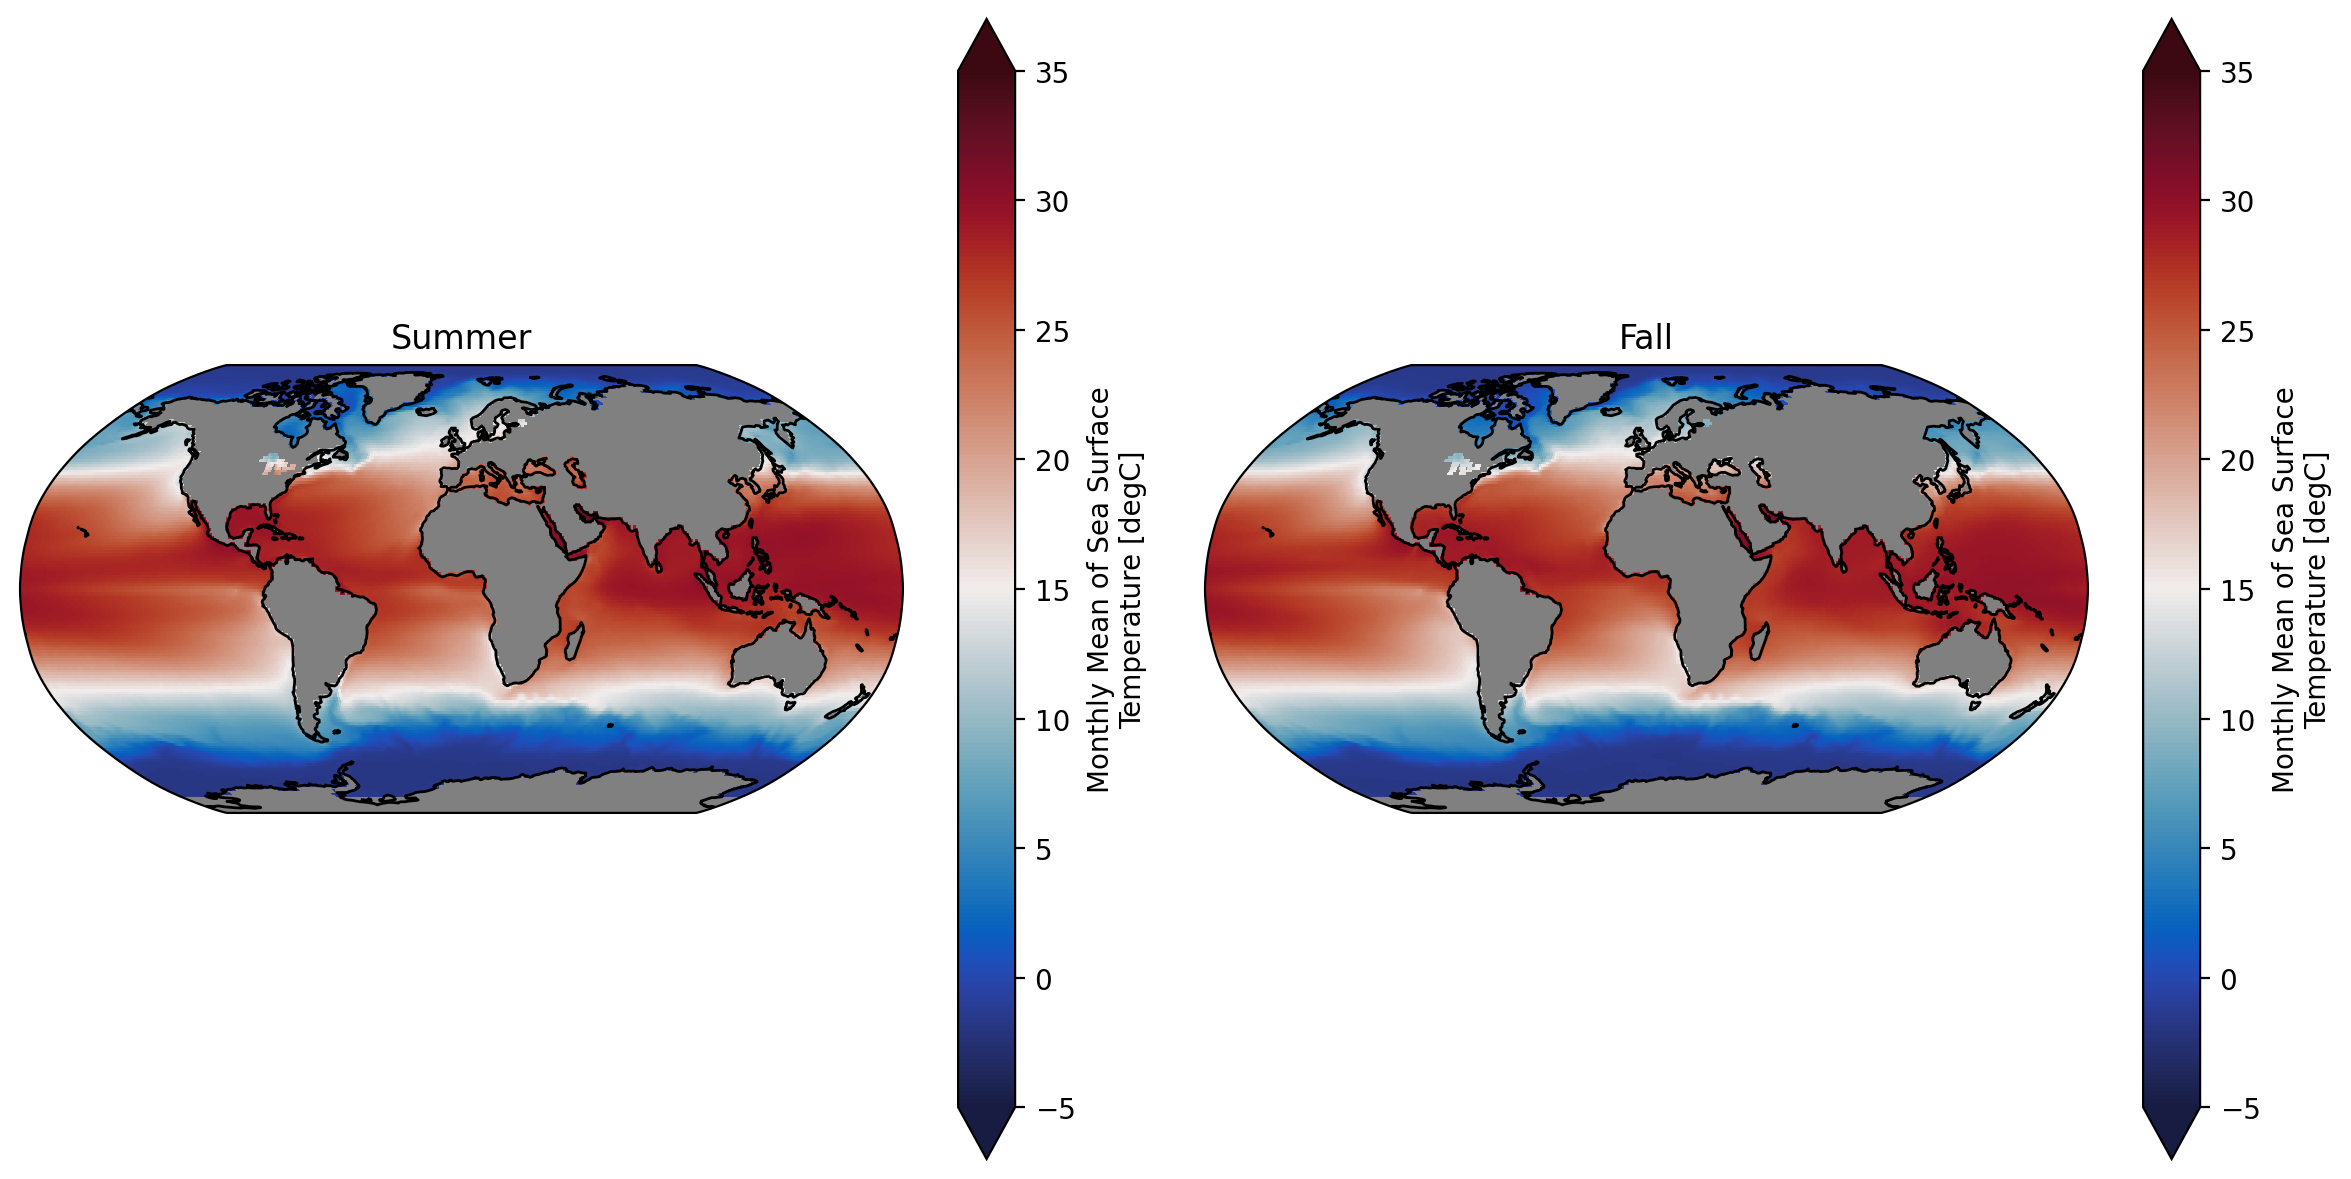

In [17]:
SST_seasons = SST.groupby('time.season').mean(dim='time')   #Averaging over each season in the SST data
DJF = SST_seasons.sel(season='DJF')
MAM = SST_seasons.sel(season='MAM')
JJA = SST_seasons.sel(season='JJA')
SON = SST_seasons.sel(season='SON')

import cmocean
import cartopy.crs as ccrs
subplot_kws=dict(projection=ccrs.Robinson(),
                 facecolor='grey')
fig, (ax0,ax1) = plt.subplots(nrows = 1, ncols = 2, subplot_kw = subplot_kws)
#plotting the first two seasons on the first figure
DJF.plot( ax=ax0,
            cmap=cmocean.cm.balance,
            vmin=-5,vmax=35, extend='both',
             transform= ccrs.PlateCarree())
MAM.plot( ax=ax1,
            cmap=cmocean.cm.balance,
            vmin=-5,vmax=35, extend='both',
             transform= ccrs.PlateCarree())
plt.tight_layout()
ax0.set_title('Winter')
ax1.set_title('Spring')
ax0.coastlines()
ax1.coastlines()

#plotting the last two seasons on the second figure
fig, (ax0,ax1) = plt.subplots(nrows = 1, ncols = 2, subplot_kw = subplot_kws)
JJA.plot( ax=ax0,
            cmap=cmocean.cm.balance,
            vmin=-5,vmax=35, extend='both',
             transform= ccrs.PlateCarree())
SON.plot( ax=ax1,
            cmap=cmocean.cm.balance,
            vmin=-5,vmax=35, extend='both',
             transform= ccrs.PlateCarree())
plt.tight_layout()
ax0.set_title('Summer')
ax1.set_title('Fall')
ax0.coastlines()
ax1.coastlines()

**Figure 2.** Global Projections of the 30 year average of Sea Surface Temperature (SST) for all four seasons. This figure was produced using the SST dataset for the past 30 years.

### Produce a visualization of the average of the most recent 5 year average minus the first 5 years and describe the spatial patterns observed.

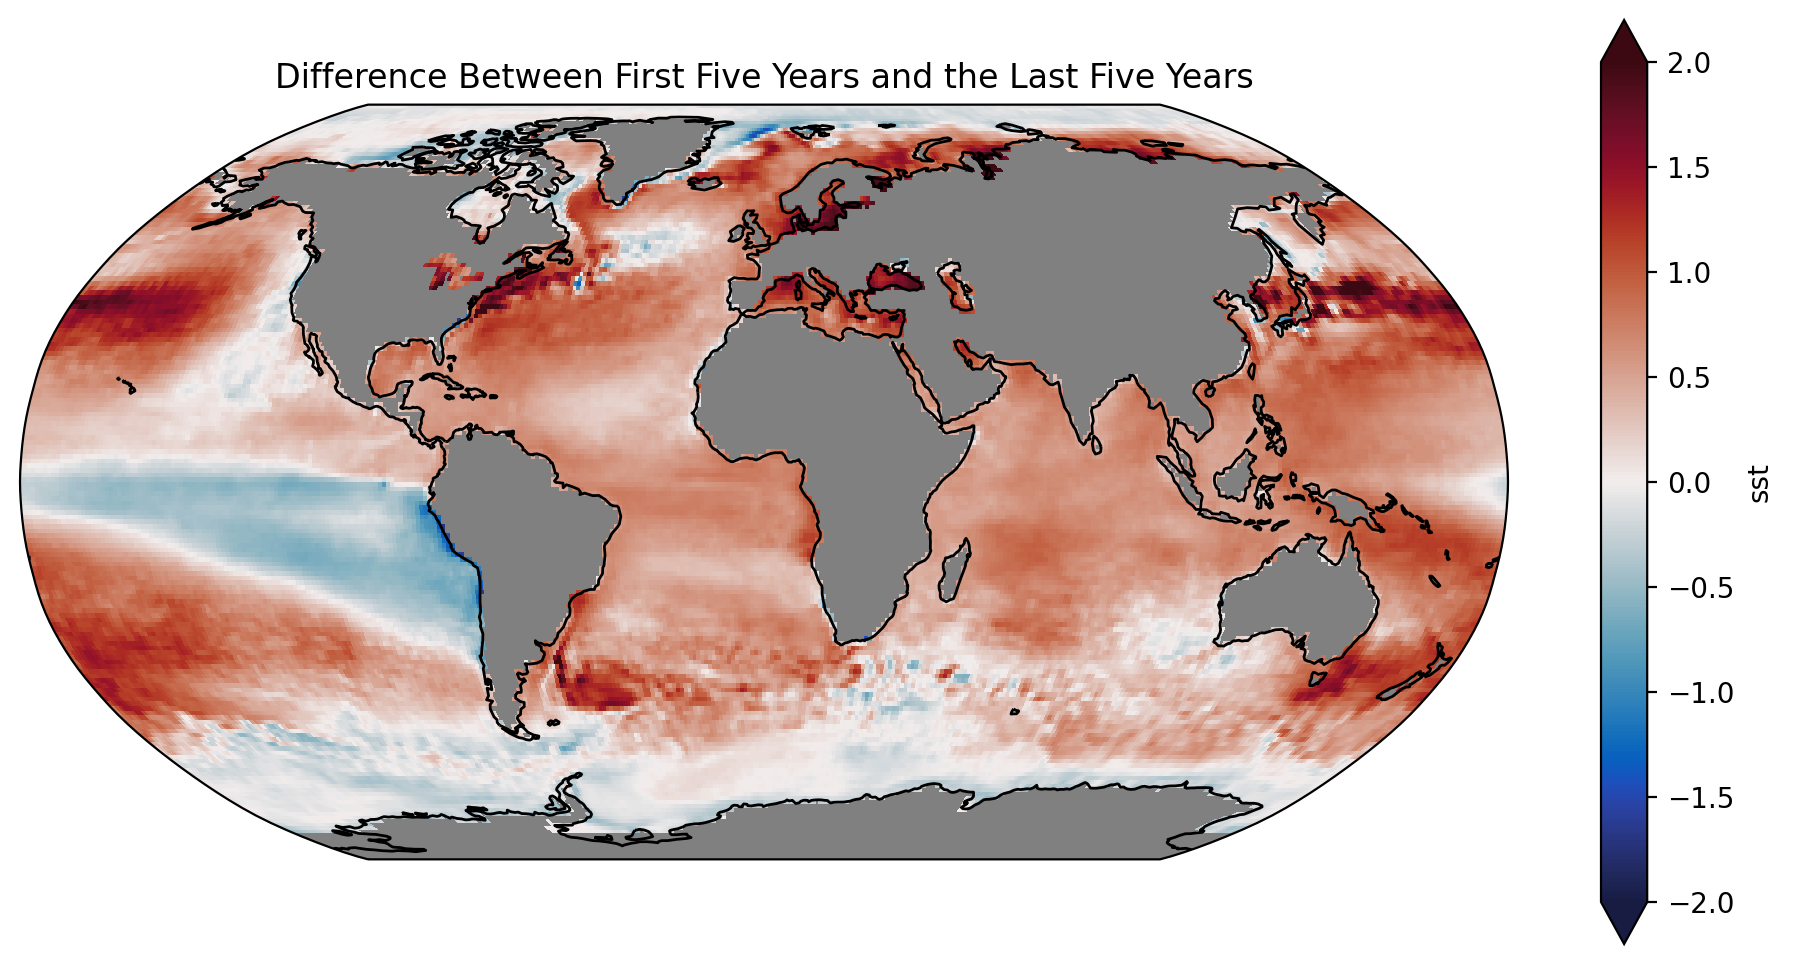

In [19]:
SST_last5 = SST.sel(time=slice('2018-01-01','2022-12-01'))  #slicing out the last 5 years of the SST data
SST_first5 = SST.sel(time=slice('1993-01-01','1997-12-01'))  #slicing out the first 5 years of the SST data

SST_last5_annual = ml.util.annual_cycle(SST_last5,tcoord='time')   #averaging over each month
SST_first5_annual = ml.util.annual_cycle(SST_first5,tcoord='time')   #averaging over each month

SST_last5_average = ml.util.annual_average(SST_last5_annual,tcoord='time').squeeze()   #averaging over each year
SST_first5_average = ml.util.annual_average(SST_first5_annual,tcoord='time').squeeze()   #averaging over each year

Difference = SST_last5_average - SST_first5_average #taking the difference betweenthe first and last 5 years

fig, ax = plt.subplots(subplot_kw = subplot_kws)
#plotting the difference calculated above
Difference.plot( ax=ax,
            cmap=cmocean.cm.balance,
            vmin=-2,vmax=2, extend='both',
             transform= ccrs.PlateCarree())

ax.set_title('Difference Between First Five Years and the Last Five Years')
ax.coastlines()

**Figure 3.** Global projection of the difference between the average of the 2018-2022 years global SST and the 1993-1997 years global SST. This figure was produced using the SST dataset for the past 30 years.

### Repeat the analysis above but considering the seasonal differences.

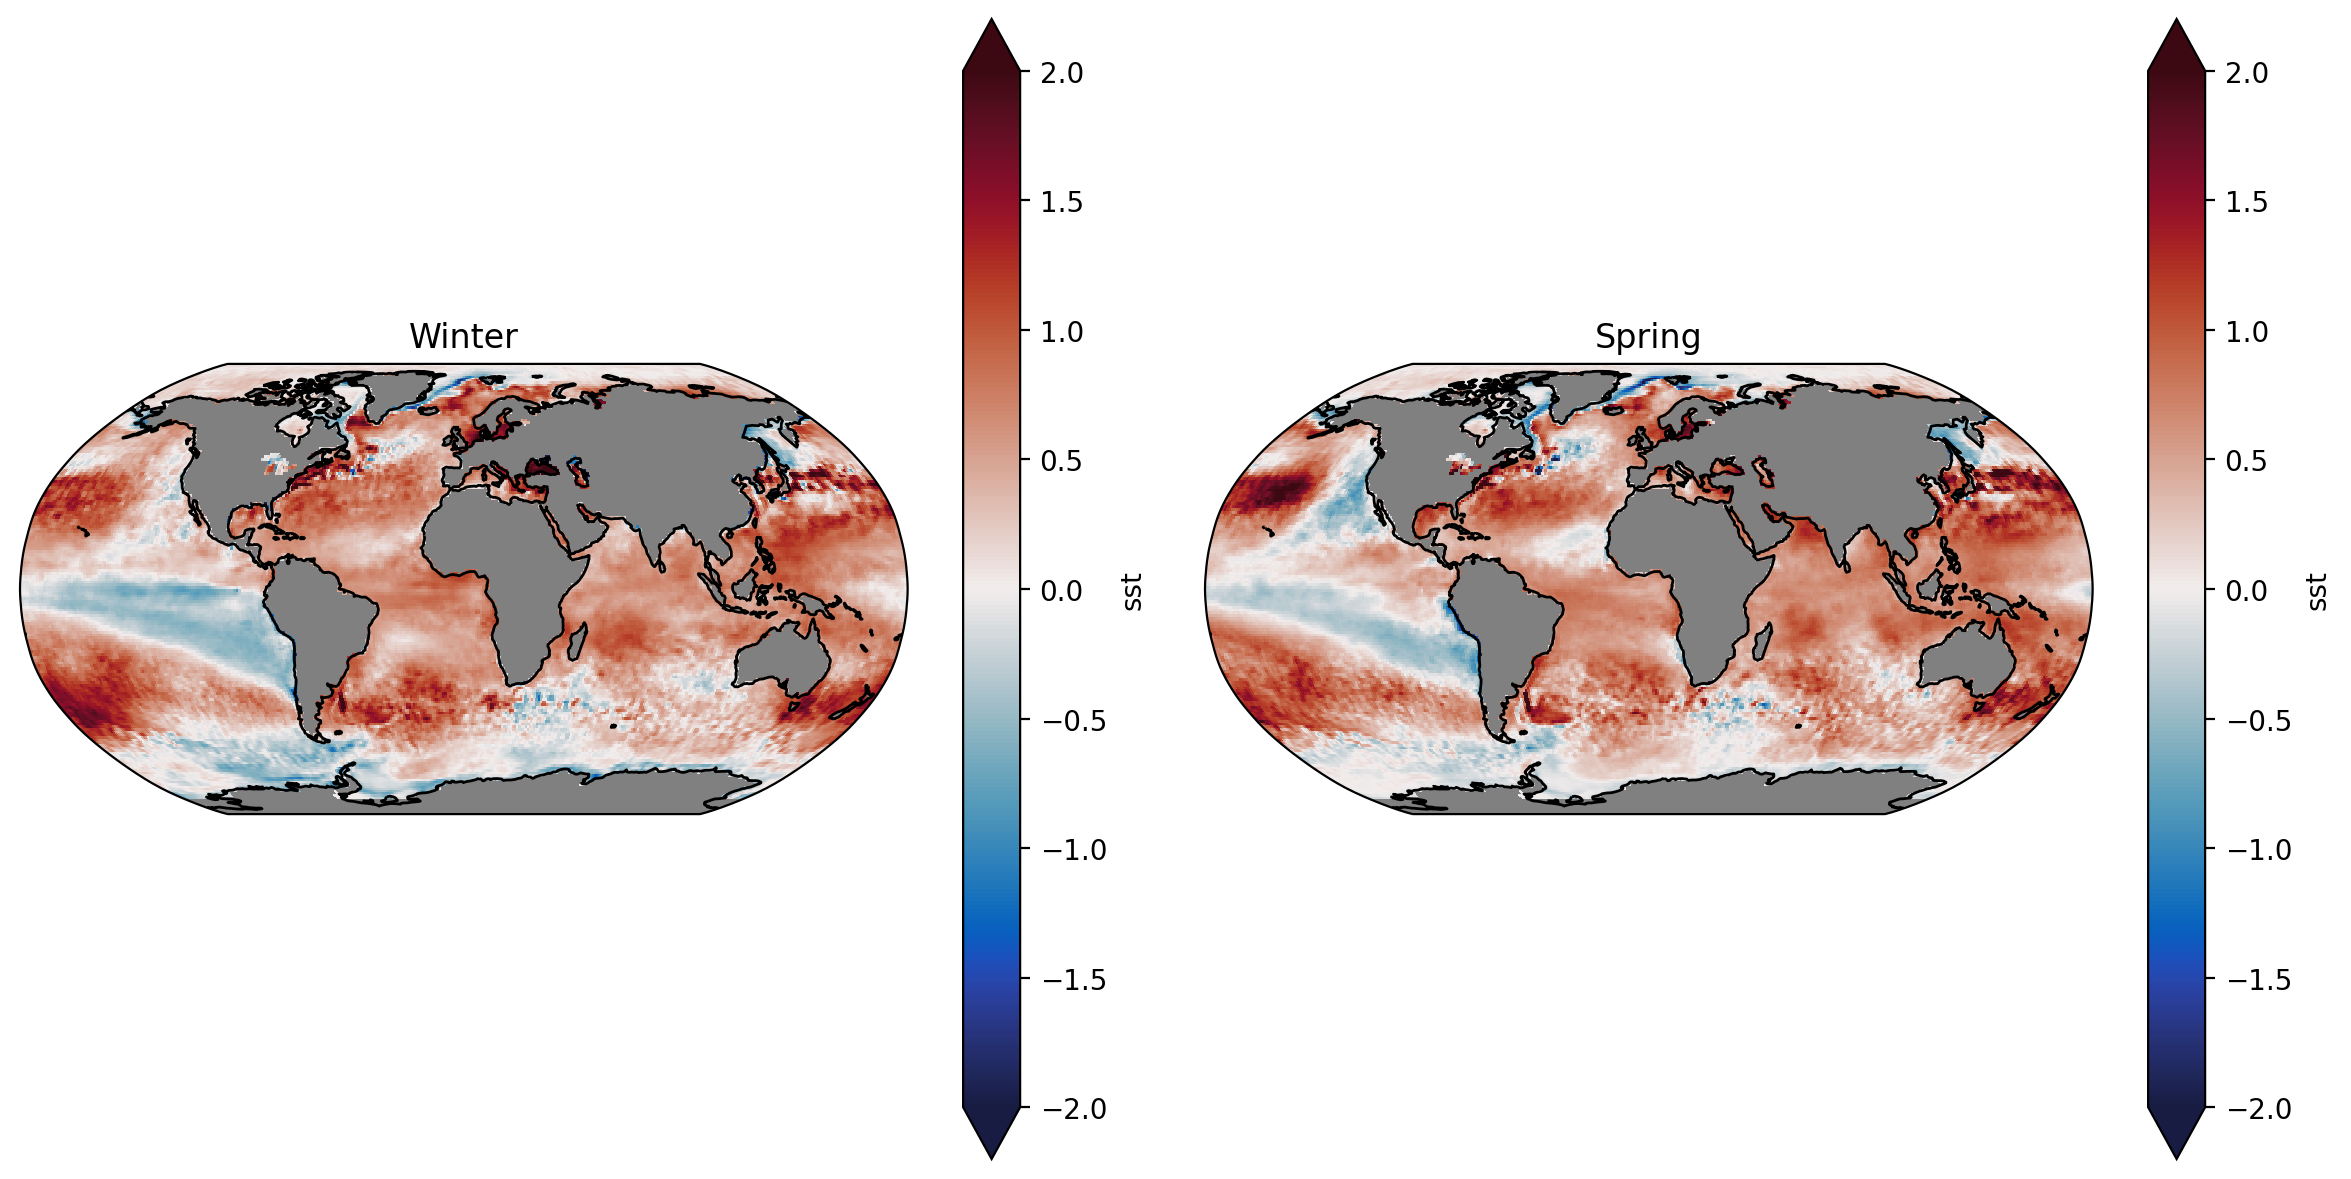

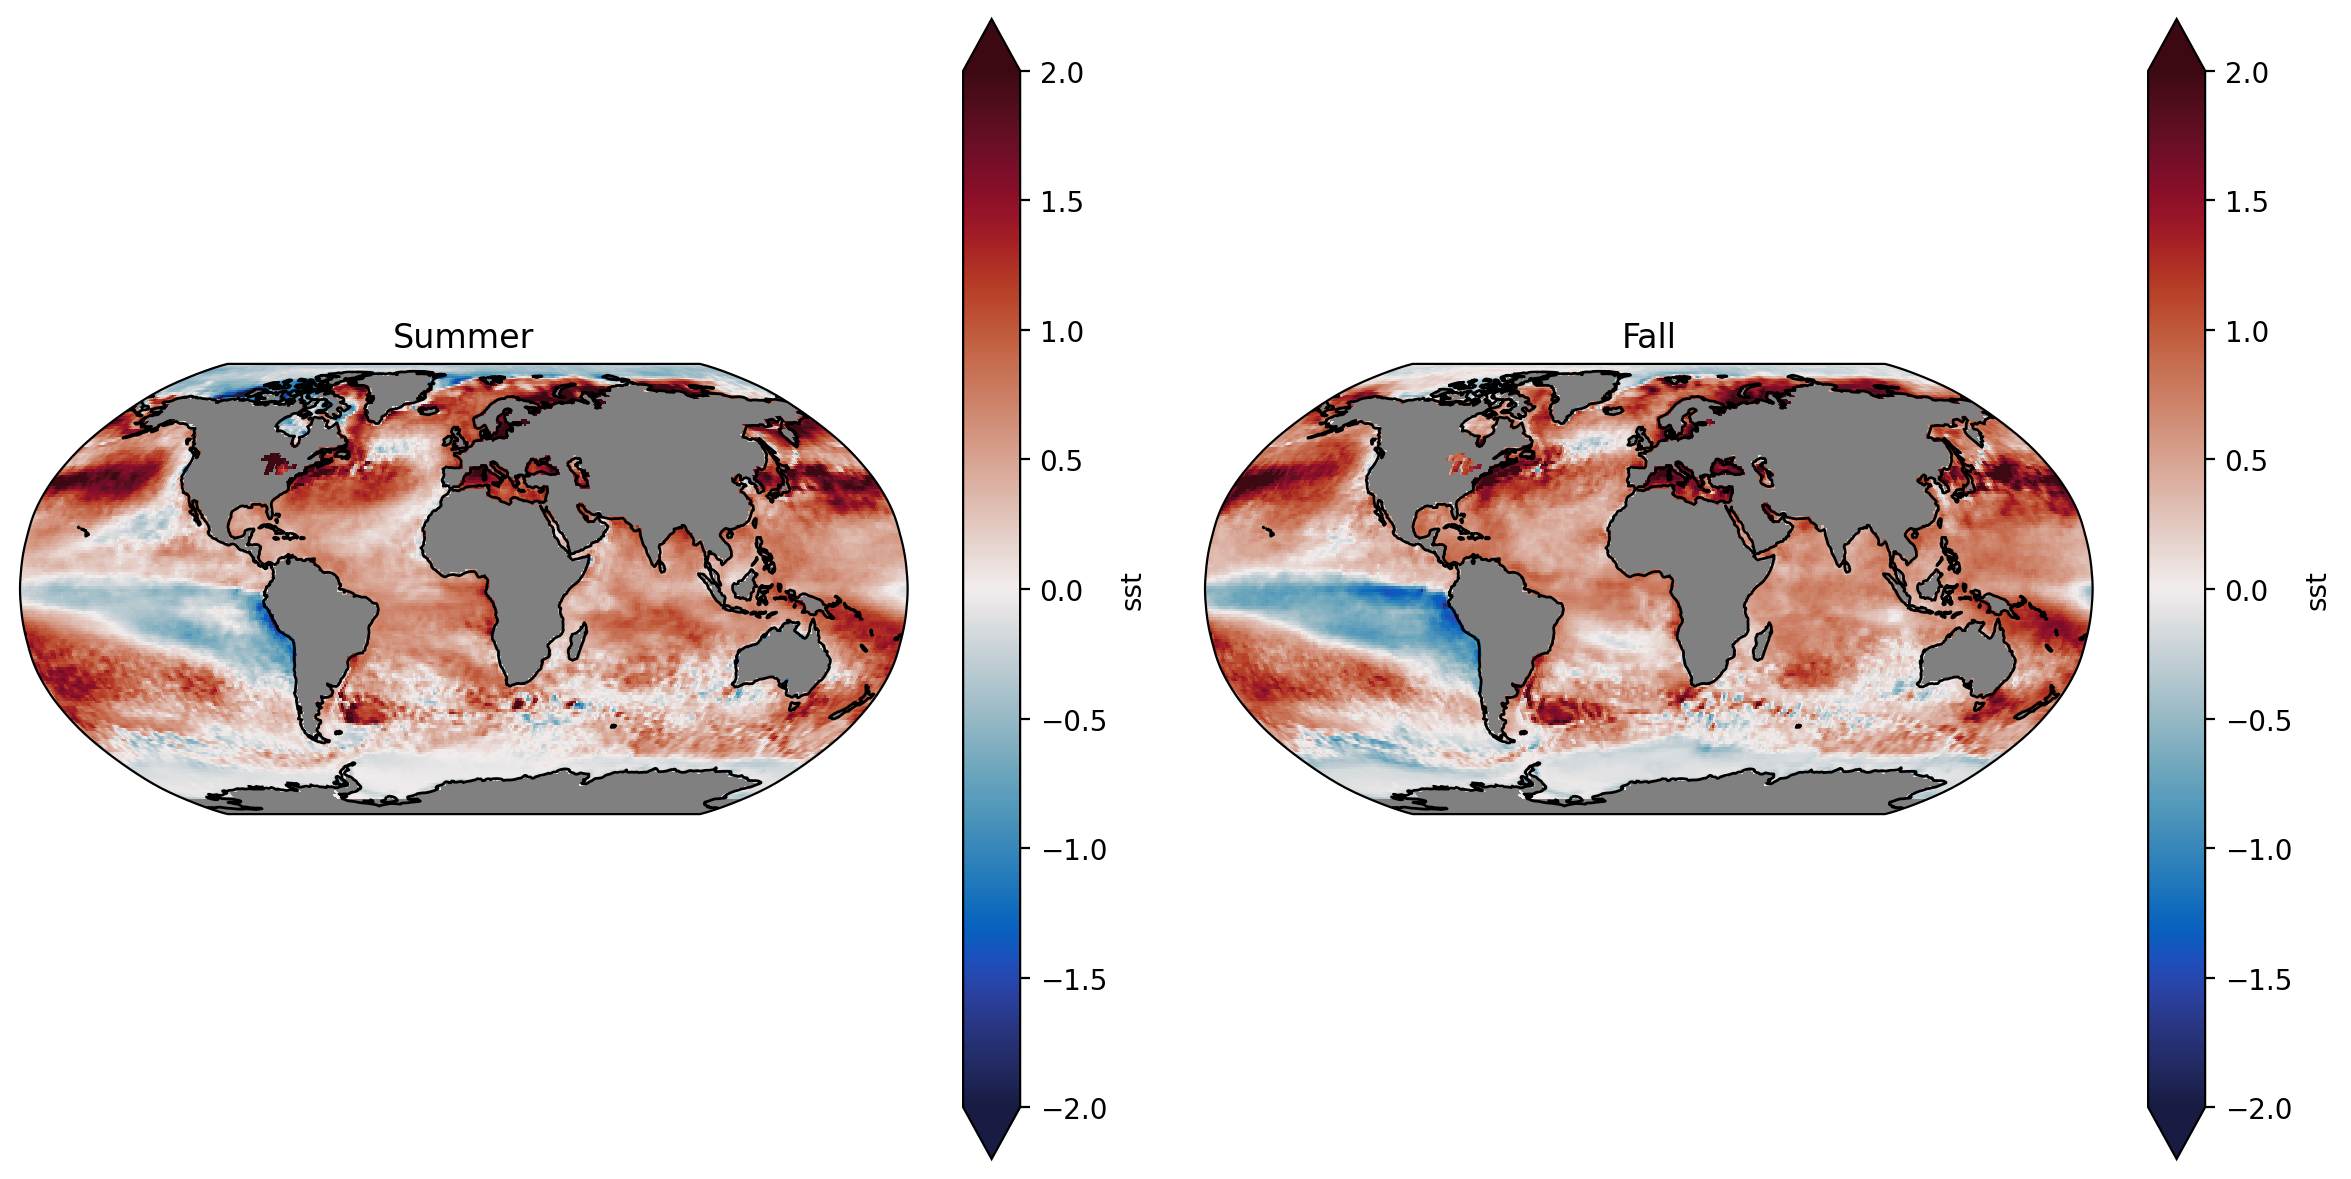

In [20]:
SST_last5 = SST.sel(time=slice('2018-01-01','2022-12-01'))  #slicing out the last 5 years of SST data
SST_first5 = SST.sel(time=slice('1993-01-01','1997-12-01'))  #slicing out the first 5 years of SST data

SST_last5_annual = ml.util.annual_cycle(SST_last5,tcoord='time')  #Averaging over each month
SST_first5_annual = ml.util.annual_cycle(SST_first5,tcoord='time')  #Averaging over each month

SST_last5_seasons = SST_last5_annual.groupby('time.season').mean(dim='time')  #grouping by season and averaging
DJF_last5 = SST_last5_seasons.sel(season='DJF') #selecting each individual season and giving it a name
MAM_last5 = SST_last5_seasons.sel(season='MAM')
JJA_last5 = SST_last5_seasons.sel(season='JJA')
SON_last5 = SST_last5_seasons.sel(season='SON')

SST_first5_seasons = SST_first5_annual.groupby('time.season').mean(dim='time')  #grouping by season and averaging
DJF_first5 = SST_first5_seasons.sel(season='DJF') #selecting each individual season and giving it a name
MAM_first5 = SST_first5_seasons.sel(season='MAM')
JJA_first5 = SST_first5_seasons.sel(season='JJA')
SON_first5 = SST_first5_seasons.sel(season='SON')

DJF_diff = DJF_last5 - DJF_first5  #taking the difference between the seasonal averages for the first 5 years and the last 5 years
MAM_diff = MAM_last5 - MAM_first5
JJA_diff = JJA_last5 - JJA_first5
SON_diff = SON_last5 - SON_first5

fig, (ax0,ax1) = plt.subplots(nrows = 1, ncols = 2, subplot_kw = subplot_kws)
#plotting the first two seasons on one figure
DJF_diff.plot( ax=ax0,
            cmap=cmocean.cm.balance,
            vmin=-2,vmax=2, extend='both',
             transform= ccrs.PlateCarree())
MAM_diff.plot( ax=ax1,
            cmap=cmocean.cm.balance,
            vmin=-2,vmax=2, extend='both',
             transform= ccrs.PlateCarree())
ax0.set_title('Winter')
ax1.set_title('Spring')
ax0.coastlines()
ax1.coastlines()
plt.tight_layout()
#plotting the last two seasons on another figure
fig, (ax0,ax1) = plt.subplots(nrows = 1, ncols = 2, subplot_kw = subplot_kws)
JJA_diff.plot( ax=ax0,
            cmap=cmocean.cm.balance,
            vmin=-2,vmax=2, extend='both',
             transform= ccrs.PlateCarree())
SON_diff.plot( ax=ax1,
            cmap=cmocean.cm.balance,
            vmin=-2,vmax=2, extend='both',
             transform= ccrs.PlateCarree())
ax0.set_title('Summer')
ax1.set_title('Fall')
plt.tight_layout()
ax0.coastlines()
ax1.coastlines()

**Figure 4.** Global projections of the difference between the average of the 2018-2022 years global SST and the 1993-1997 years global SST, split into the four seasons. This figure was produced using the SST dataset for the past 30 years.

### Assess the annual - mean SST anomalies in 2022 compared to the 1993 to 2022 climatological average. What patterns stand out in 2022? 

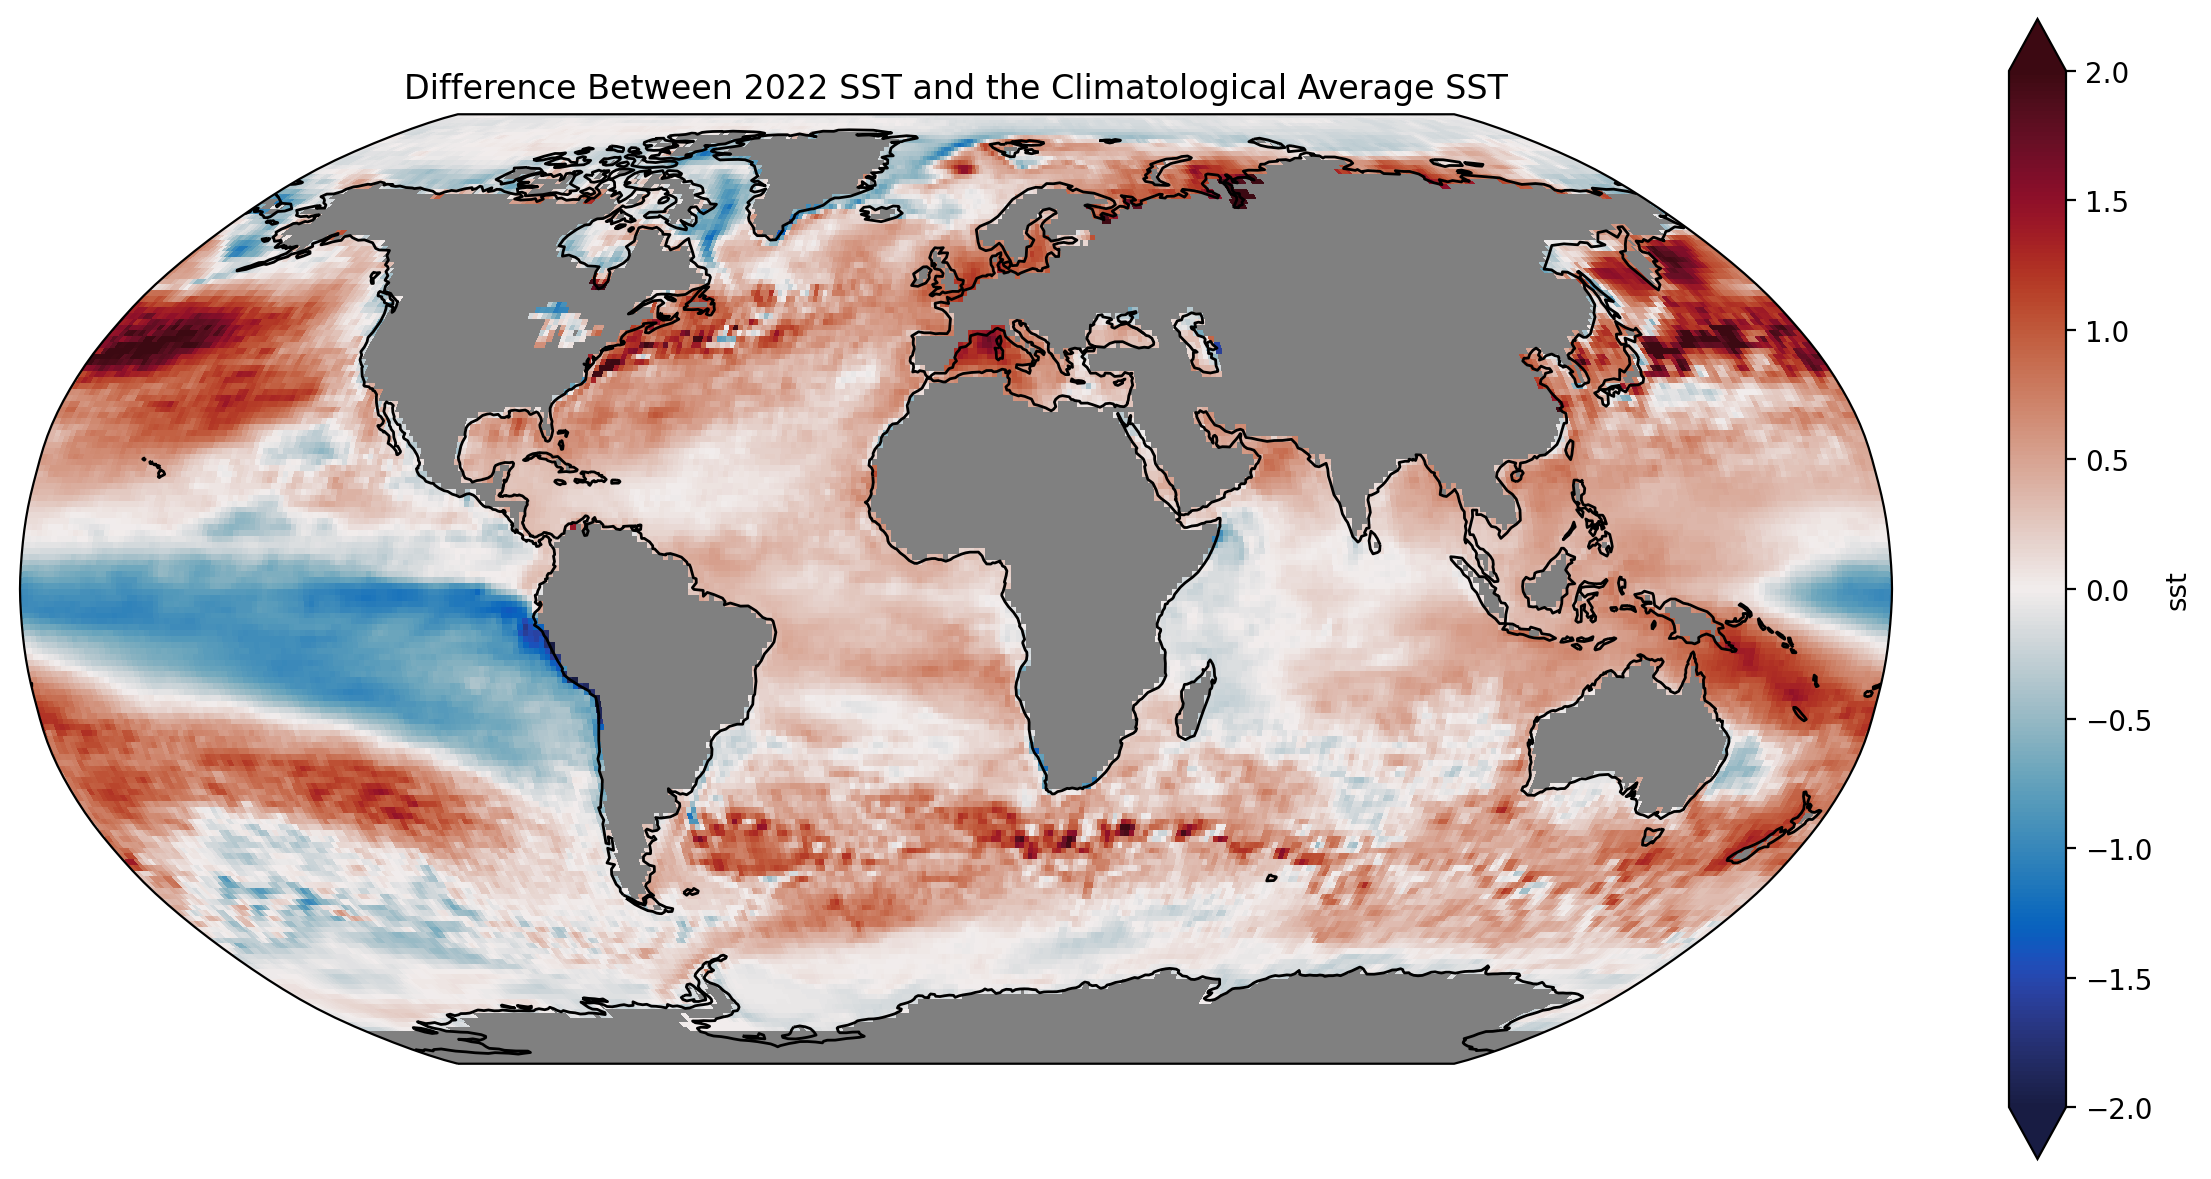

In [22]:
SST_2022 = SST.sel(time=slice('2022-01-01','2022-12-01'))  #slicing out the 2022 year of SST data
                   
SST_annual = ml.util.annual_cycle(SST,tcoord='time')  #averaging over every month
SST_2022_annual = ml.util.annual_cycle(SST_2022,tcoord='time') #averaging over every month in 2022

SST_annual_average = ml.util.annual_average(SST_annual,tcoord='time').squeeze()  #Averaging over the years
SST_2022_average = ml.util.annual_average(SST_2022_annual,tcoord='time').squeeze() #averaging over the years

Diff_2022 = SST_2022_average - SST_annual_average #taking the difference betwween 2022 and the 30 year average

fig, ax = plt.subplots(subplot_kw = subplot_kws)
#plotting that difference
Diff_2022.plot( ax=ax,
            cmap=cmocean.cm.balance,
            vmin=-2,vmax=2, extend='both',
             transform= ccrs.PlateCarree())
ax.set_title('Difference Between 2022 SST and the Climatological Average SST')
ax.coastlines()
plt.tight_layout()

**Figure 5.** Global projection of the difference between the 2022 global SST and the 30 year average global SST. This figure was produced using the SST dataset for the past 30 years.

Sea Surface Temperature is something that is not always an obvious factor when looking at the effects of climate change. While it is true that the SST hasn't changed as much as atmospheric temperatures have, that is mostly due to the specific heat capacity of water, as it requires a lot more energy to heat it up that air does. Looking at these charts for the past 30 years it is still very obvious that SST is increasing and will likely continue to increase as the effects of global warming continue into the future.